# CNN Cancer Detection Kaggle Mini-Project
**GitHub Repository**: https://github.com/ilichenko/DTSA-5511

Useful guide on how to install TensorFlow in Jupyter Notebook: https://how.dev/answers/how-to-install-tensorflow-in-jupyter-notebook

## 1. Introduction
### 1.1. Problem Statement
This study examines the application of deep learning models to identify metastatic tissue in histopathologic scans of lymph node sections. The task is a binary image classification problem, where each image patch must be classified as either containing metastatic tissue (positive) or not (negative). 

### 1.2. Study Objective
The objective of the study is to develop several deep learning models and determine which one has the highest AUC value for detencing cancer.

### 1.3. Dataset Overview
The dataset contains the following:
- **Training Set**: 220,025 RGB images of size 96x96 pixels.
- **Test Set**: 57,458 RGB images of the same dimensions.
- **Labels**: Provided in `train_labels.csv`, indicating the presence `1` or absence `0` of metastatic tissue.

Each image is a small patch extracted from a larger digital pathology scan. A positive label indicates that the center 32x32 pixel region contains metastatic tissue.

## 2. Exploratory Data Analysis (EDA)

The following code installs the required libraries and imports the data:

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path    
from PIL import Image
from tqdm import tqdm

In [42]:
TRAIN_DIR = Path("train")
TEST_DIR = Path("test")
LABELS_PATH = Path("train_labels.csv")

labels_df = pd.read_csv(LABELS_PATH)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Next, we want to investigate the null and duplicate values in the data:

In [43]:
print("Missing values in labels:", labels_df.isnull().sum().sum())
print("Duplicate entries:", labels_df.duplicated().sum())

Missing values in labels: 0
Duplicate entries: 0


Thus, no data cleaning is required. Now we observe the distribution of the labels:

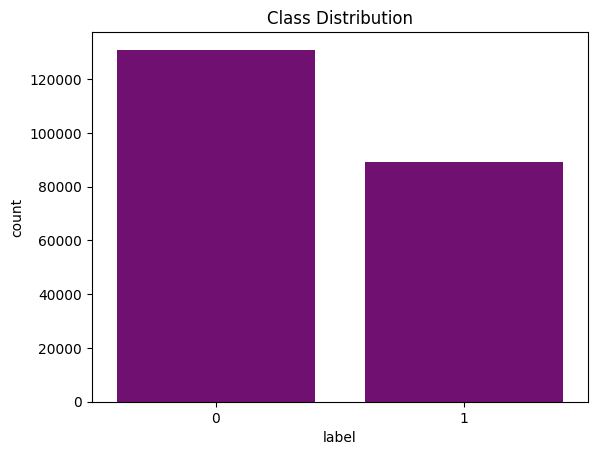

In [44]:
sns.countplot(x='label', data=labels_df, color='purple')
plt.title('Class Distribution')
plt.show()

Here are some samples from the dataset, where the first row shows the presence and the second row the absence of metastatic tissue:

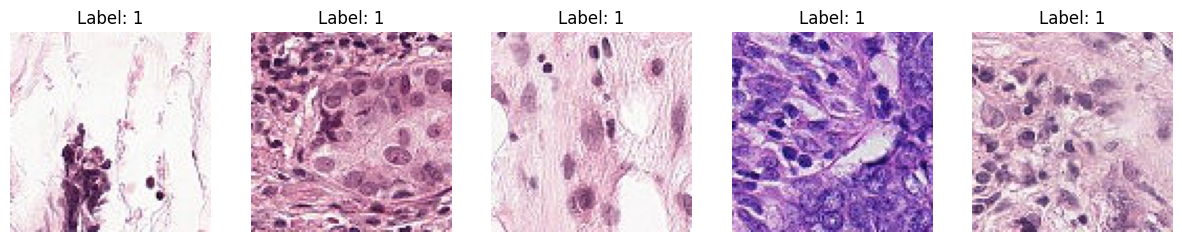

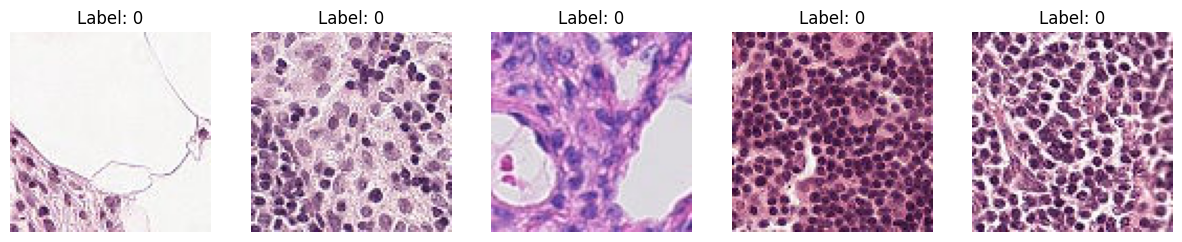

In [45]:
def display_images(label, num_images=5):
    sample_ids = labels_df[labels_df['label'] == label]['id'].values[:num_images]
    plt.figure(figsize=(15,5))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

display_images(label=1)
display_images(label=0)

## 3. Data Preprocessing

For our analysis, we load 5,000 random images of size 64x64 pixels from the original dataset:

In [46]:
from sklearn.model_selection import train_test_split

SAMPLE_SIZE = 5000
sample_df = labels_df.sample(SAMPLE_SIZE, random_state=7)

def load_images(df, img_dir, img_size):
    images = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        img_path = os.path.join(img_dir, f"{row['id']}.tif")
        img = Image.open(img_path).resize((img_size, img_size))
        images.append(np.array(img))
        labels.append(row['label'])
    return np.array(images), np.array(labels)

IMG_SIZE = 64
X, y = load_images(sample_df, TRAIN_DIR, IMG_SIZE)

100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1190.65it/s]


In [47]:
X = X / 255.0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

## 4. Model Building

After we preprocessed the data, we can start building the models. We define the following layers for our baseline model:
- **Conv2D layers** extract visual features like edges and textures. We progressively increase the number of filters (32 → 64 → 128) to learn increasingly complex features.
- **MaxPooling2D layers** downsample feature maps to reduce computational cost and help generalize the model.
- **Flatten** converts the 3D feature maps into a 1D vector so we can connect it to dense layers.
- **Dense layers** serve as fully connected decision layers. The final `Dense(1, activation='sigmoid')` outputs a probability for binary classification (cancer vs. non-cancer).

In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_baseline_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = build_baseline_cnn((IMG_SIZE, IMG_SIZE, 3))
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
baseline_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

Now we will define the following 2 models with VGG16 and ResNet50 since these models were pre-trained on large image datasets. For both, we use fully connected layers with 256 neurons as a standard middle ground and a 50% dropout to randomly disable the half of neurons during training which helps preventing overfitting:

In [67]:
from tensorflow.keras.applications import VGG16

def build_vgg16_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

vgg16_model = build_vgg16_model((IMG_SIZE, IMG_SIZE, 3))
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

In [68]:
from tensorflow.keras.applications import ResNet50

def build_resnet50_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

resnet50_model = build_resnet50_model((IMG_SIZE, IMG_SIZE, 3))
resnet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

## 5. Model Training

In the next step, we train our 3 models for 10 epochs with a batch size of 32 to see trends without overcommitting resources:

In [69]:
baseline = baseline_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - auc: 0.6218 - loss: 0.6852 - val_auc: 0.8344 - val_loss: 0.5266
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8331 - loss: 0.4931 - val_auc: 0.8444 - val_loss: 0.4962
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8548 - loss: 0.4641 - val_auc: 0.8528 - val_loss: 0.4742
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8528 - loss: 0.4690 - val_auc: 0.8621 - val_loss: 0.4722
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8734 - loss: 0.4374 - val_auc: 0.8385 - val_loss: 0.4936
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8722 - loss: 0.4387 - val_auc: 0.8647 - val_loss: 0.4646
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8943 - loss: 0.4045 - val_auc: 0.8664 - val_loss: 0.4548
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8982 - loss: 0.3979 - val_auc: 0.8637 - val_loss: 0.4628
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/

In [70]:
vgg16 = vgg16_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - auc: 0.7359 - loss: 0.6155 - val_auc: 0.8437 - val_loss: 0.4794
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - auc: 0.8487 - loss: 0.4652 - val_auc: 0.8516 - val_loss: 0.4674
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - auc: 0.8625 - loss: 0.4464 - val_auc: 0.8534 - val_loss: 0.4602
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - auc: 0.8848 - loss: 0.4138 - val_auc: 0.8586 - val_loss: 0.4529
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - auc: 0.8976 - loss: 0.3937 - val_auc: 0.8644 - val_loss: 0.4440
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - auc: 0.8918 - loss: 0.4010 - val_auc: 0.8639 - val_loss: 0.4567
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - auc: 0.8939 - loss: 0.3987 - val_auc: 0.8646 - val_loss: 0.4559
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - auc: 0.9055 - loss: 0.3738 - val_auc: 0.8650 - val_loss: 0.4556
Epoch 9/10
125/125 ━━━━━━━━━━━━━

In [71]:
resnet50 = resnet50_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - auc: 0.5274 - loss: 0.7025 - val_auc: 0.7140 - val_loss: 0.6482
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - auc: 0.6128 - loss: 0.6545 - val_auc: 0.7330 - val_loss: 0.6405
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - auc: 0.6595 - loss: 0.6417 - val_auc: 0.7397 - val_loss: 0.6340
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - auc: 0.6905 - loss: 0.6332 - val_auc: 0.7452 - val_loss: 0.6271
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - auc: 0.6825 - loss: 0.6315 - val_auc: 0.7573 - val_loss: 0.6113
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - auc: 0.7261 - loss: 0.6037 - val_auc: 0.7632 - val_loss: 0.5967
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - auc: 0.7426 - loss: 0.5945 - val_auc: 0.7647 - val_loss: 0.5844
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - auc: 0.7369 - loss: 0.5904 - val_auc: 0.7709 - val_loss: 0.5818
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 

## 6. Model Evaluation

Next, we evaluate the model results using AUC metric:

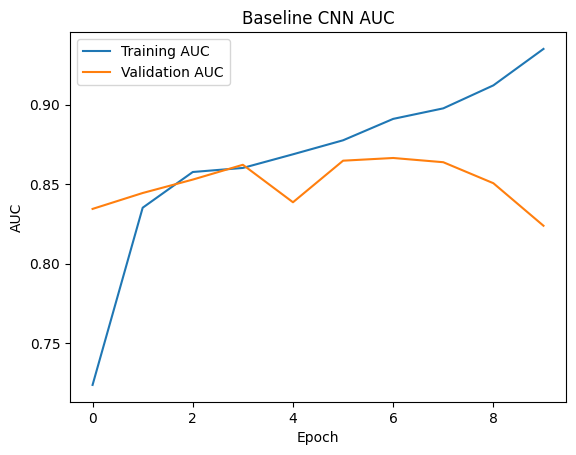

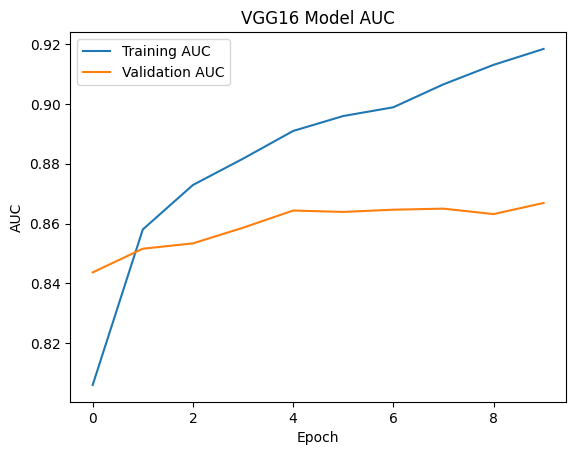

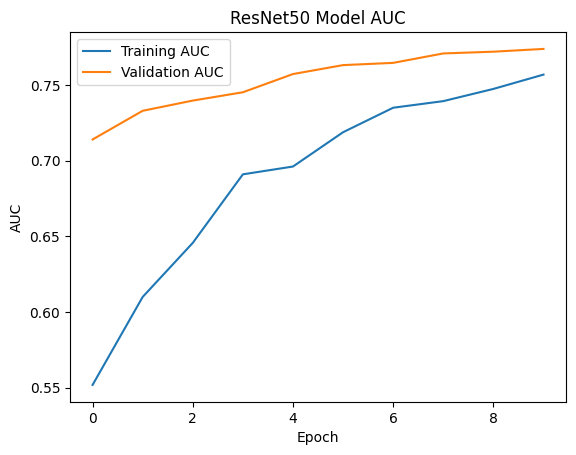

In [81]:
def plot_auc(model, title):
    plt.plot(model.history['auc'], label='Training AUC')
    plt.plot(model.history['val_auc'], label='Validation AUC')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

plot_auc(baseline, 'Baseline CNN AUC')
plot_auc(vgg16, 'VGG16 Model AUC')
plot_auc(resnet50, 'ResNet50 Model AUC')

- Baseline CNN:
    - shows a good performance,
    - the peak validation AUC was reached early,
    - the training AUC keeps improving, but the validation AUC drops which is a sign of a mild overfitting.
- VGG16:
    - shows the best performance,
    - the validation AUC is stable,
    - consistent generalization.
- ResNet50:
    - the worst performance due to a very weak start, thus needs tuning.

In [73]:
from sklearn.metrics import roc_auc_score

y_pred_baseline = baseline_model.predict(X_val)
y_pred_vgg16 = vgg16_model.predict(X_val)
y_pred_resnet50 = resnet50_model.predict(X_val)

auc_baseline = roc_auc_score(y_val, y_pred_baseline)
auc_vgg16 = roc_auc_score(y_val, y_pred_vgg16)
auc_resnet50 = roc_auc_score(y_val, y_pred_resnet50)

print(f"Baseline CNN ROC-AUC: {auc_baseline}")
print(f"VGG16 Model ROC-AUC: {auc_vgg16}")
print(f"ResNet50 Model ROC-AUC: {auc_resnet50}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step  
Baseline CNN ROC-AUC: 0.8237258289587348
VGG16 Model ROC-AUC: 0.8670343544421557
ResNet50 Model ROC-AUC: 0.7738304870755531


Considering ROC-AUC results on the validation set, we conclude that VGG16 captures true class distributions better than the others. Thus, we take VGG16 as a baseline for the hyperparameter tuning trying to achieve even better AUC.

## 7. Hyperparameter Tuning for VGG16

We tune the following hyperparameters using Keras Tuner:
- Dense units: 64–512;
- Dropout rate: 0.3–0.7;
- Learning rate: 1e-4, 5e-4, 1e-3.

In [60]:
from keras_tuner import RandomSearch
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_vgg16_model_tuned(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(1, activation='sigmoid')])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3])),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')])

    return model

tuner = RandomSearch(
    build_vgg16_model_tuned,
    objective='val_auc',
    max_trials=10,
    executions_per_trial=1,
    directory='vgg16_tuning',
    project_name='histopathology')

tuner.search(X_train, 
             y_train,
             epochs=5,
             validation_data=(X_val, y_val),
             batch_size=32)

Trial 10 Complete [00h 01m 53s]
val_auc: 0.8510615229606628

Best val_auc So Far: 0.859315812587738
Total elapsed time: 00h 50m 00s


In [61]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
print(f"Best hyperparameters: {best_hyperparams.values}")

Best hyperparameters: {'dense_units': 512, 'dropout_rate': 0.5, 'learning_rate': 0.001}


/Users/yaroslavilichenko/miniconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [75]:
vgg16_best = best_model.fit(X_train, 
                            y_train,
                            validation_data=(X_val, y_val),
                            epochs=15,
                            batch_size=32)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - auc: 0.9337 - loss: 0.3180 - val_auc: 0.8763 - val_loss: 0.4482
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - auc: 0.9291 - loss: 0.3311 - val_auc: 0.8679 - val_loss: 0.4693
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - auc: 0.9330 - loss: 0.3228 - val_auc: 0.8749 - val_loss: 0.4444
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - auc: 0.9330 - loss: 0.3195 - val_auc: 0.8738 - val_loss: 0.4464
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - auc: 0.9389 - loss: 0.3062 - val_auc: 0.8777 - val_loss: 0.4450
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - auc: 0.9425 - loss: 0.3032 - val_auc: 0.8776 - val_loss: 0.4489
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - auc: 0.9385 - loss: 0.3077 - val_auc: 0.8736 - val_loss: 0.4596
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - auc: 0.9391 - loss: 0.3065 - val_auc: 0.8782 - val_loss: 0.4540
Epoch 9/15
125/125 ━━━━━━━━━━━━━

In [80]:
y_pred_vgg16_best = best_model.predict(X_val)
auc_vgg16_best = roc_auc_score(y_val, y_pred_vgg16_best)
print(f"VGG16 Best Model ROC-AUC: {auc_vgg16_best}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step
VGG16 Best Model ROC-AUC: 0.8764618911555586


Thus, we improved the final ROC-AUC value on the validation set and the hyperparameter tuning can be considered successful. This can be also observed on the following plot:

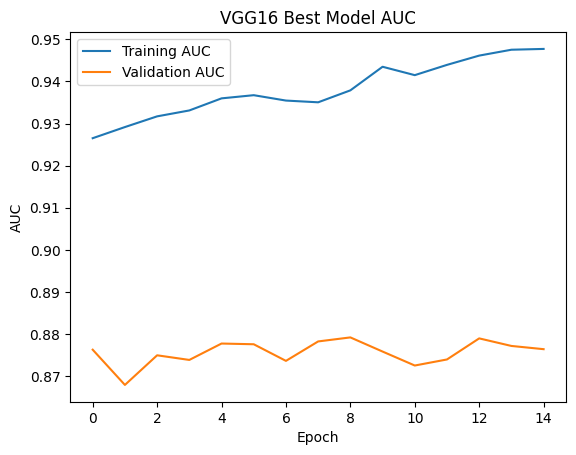

In [82]:
plot_auc(vgg16_best, 'VGG16 Best Model AUC')

## 8. Generating Submission File

We select the tuned VGG16 model for generating the final submission:

In [78]:
def load_test_images(img_dir, img_size):
    images = []
    image_ids = []
    for img_name in tqdm(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path).resize((img_size, img_size))
        images.append(np.array(img))
        image_ids.append(img_name.split('.')[0])
    return np.array(images), image_ids

X_test, test_ids = load_test_images(TEST_DIR, IMG_SIZE)
X_test = X_test / 255.0

100%|███████████████████████████████████| 57458/57458 [00:26<00:00, 2192.02it/s]


In [79]:
test_preds = resnet50_model.predict(X_test)
submission_df = pd.DataFrame({'id': test_ids, 'label': test_preds.flatten()})
submission_df.to_csv('submission.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 110s 61ms/step


## 9. Conclusion

In this study, we created and trained 3 models, a baseline model, a VGG16 model and a ResNet50 model, and evaluate their results. We observed that VGG16 made more meaningful probability predictions thus we performed some hyperparameter tuning and achieved even better results. In the context of this project, the main objective was successfully accomplished. However, more could be considered in the following iterations, e.g.:
- reducing model complexity in the dense layer which might lead to overfitting,
- experimenting with image sizes as ResNet’s complexity could not align with the one we used.

## 10. References

- Geena Kim. DTSA 5511 Introduction to Deep Learning
- Geeksforgeeks. VGG-16: https://www.geeksforgeeks.org/vgg-16-cnn-model/
- Geeksforgeeks. Image Classification using ResNet: https://www.geeksforgeeks.org/image-classification-using-resnet/
- Vinicius Queiroz / Medium. Using Keras Tuner to Find the Best Hyperparameters for Your Neural Network Model: https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203